In [1]:
from sinkhorn_663 import sinkhorn, log_domain_sinkhorn, sinkhorn_numba, sinkhorn_numba_parallel
from sinkhorn_663 import sample_to_prob_vec, sample_to_prob_vec_nD
from skh_cpp import sinkhorn_cpp
import numpy as np
import matplotlib.pyplot as plt
from sinkhorn_663.image import cost_mat, flatten, remove_zeros

## 2.1 Basic implementation

First, we follow the above description of algorithm to implement it in plain Python as a baseline. We use the functions in package *numpy* to do matrix operations. The Sinkhorn distance and iteration times would be returned. As in the above description, the algorithm could calculate the matrix $P^{\lambda}$ by Sinkhorn's fixed point iteration $(u, v) \leftarrow (r./Kv, c./K'u)$. Furthermore, the iteration could been simplified to one single iteration $u\leftarrow 1./(\tilde K(c./K'u))$. We use $|u_{new} - u|<tol$ as the stopping criterion.

In [3]:
def Sinkhorn_plain(r, C, M, lamda, tol = 1e-6, maxiter = 10000):
    M = M[r > 0]
    r = r[r > 0]
    K = np.exp(-lamda * M)
    N = np.shape(C)[1]
    u = np.ones((len(r), N)) / len(r)
    K_tilde = np.diag(1/r) @ K
    d_prev = np.repeat(2., N)
    d = np.ones(N) + 0.5
    for i in range(maxiter):
        u_new = 1/(K_tilde @ (C / (K.T @ u)))
        if np.max(np.abs(u_new - u)) <= tol:
            break
        u = u_new
    v = C/(K.T @ u)
    d = np.sum(u * ((K * M) @ v), axis = 0)
    return d[0], i

### 2.1.1 Test  with simulation data and check results

To verify the correctness of our implementation, we generate some simulation data and test the algorithm on it. Further optimized algorithms would also be tested on them to check results and compare performance. 

As a start, we consider the situation where the empirical measures $r$ and $c$ come from a same distribution. We generate two groups of samples from a same distribution $\text{Beta}(1, 2)$, use the function *sample_to_prob_vec* to convert samples to vectors and cost matrix as inputs, and calculate the distance by our function. Here we choose sample size $N = 3000$, $\text{maxiter} = 10000$, $\text{tol} = 1e-6$, $\lambda = 20$. The result is close to $0$ es expected. It is a little larger than $0$ because of the entropy regularization.

In [7]:
# create simulation data
N = 3000
np.random.seed(1)
u1 = np.random.beta(a = 1, b = 2, size = N)
v1 = np.random.beta(a = 1, b = 2, size = N)
M1, r1, c1 = sample_to_prob_vec(u1, v1)
c1 = c1.reshape(-1, 1)
# set parameters
maxiter = 10000
tol = 1e-6
lamda = 20

In [5]:
Sinkhorn_plain(r1, c1, M1, lamda, tol, maxiter)

(0.047851415045381665, 36)

Then we test on another simulation data from distributions with a setted known OT distance. Distributions $\text{Uniform}(0, 1)$ and $\text{Uniform}(10, 11)$ are used, which have a known OT distance $= 10$. The output of *Sinkhorn_plain* is close to 10 and a little larger than $10$ as expected.

In [60]:
np.random.seed(1)
u2 = np.random.uniform(0, 1, size = N)
v2 = np.random.uniform(10, 11, size = N)
M2, r2, c2 = sample_to_prob_vec(u2, v2, 1)
c2 = c2.reshape(-1, 1)

In [7]:
Sinkhorn_plain(r2, c2, M2, lamda, tol, maxiter)

(10.061646663537982, 241)

### 2.1.2 Profiling

Before diving deeper to optimization, we first use *profile* to profile the plain version of implementation.

In [8]:
import profile

In [9]:
profile.run("Sinkhorn_plain(r1, c1, M1, lamda, tol, maxiter)")

         346 function calls in 5.819 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 :0(abs)
        2    0.000    0.000    0.000    0.000 :0(array)
        2    0.000    0.000    0.000    0.000 :0(empty)
        1    0.000    0.000    5.819    5.819 :0(exec)
        2    0.000    0.000    0.000    0.000 :0(getattr)
       43    0.002    0.000    0.077    0.002 :0(implement_array_function)
        1    0.000    0.000    0.000    0.000 :0(isinstance)
       38    0.001    0.000    0.001    0.000 :0(items)
        3    0.000    0.000    0.000    0.000 :0(len)
       38    0.008    0.000    0.008    0.000 :0(reduce)
        1    0.000    0.000    0.000    0.000 :0(repeat)
        1    0.000    0.000    0.000    0.000 :0(setprofile)
        1    0.057    0.057    0.057    0.057 :0(zeros)
       37    0.003    0.000    0.021    0.001 <__array_function__ internals>:2(amax)
        2  

## 2.2 Optimization

(Descirbe numba, cpp, log_domain versions)

### Time

In [10]:
%timeit Sinkhorn_plain(r2, c2, M2, lamda, tol, maxiter)
%timeit Sinkhorn(r2, c2, M2, lamda, tol, maxiter)
%timeit Sinkhorn_cpp(r2, c2, M2, lamda, tol, maxiter)

1.4 s ± 59.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.83 s ± 292 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
459 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Overflow

Another issue is that we need to calculate $K = e^{-\lambda M}$ in our algorithm. When $\lambda$ becomes large, it may overflow and become unable to calculate the distance. To address this problem, we implement the algorithm in log domain and compile it with numba. Then we compare the results of Sinkhorn and log-domain Sinkhorn algorithms when $\lambda$ is increasing in a larger range.


In [13]:
lamda = np.linspace(120, 180, 61)
skh_res = np.zeros(61)
log_skh_res = np.zeros(61)
test_samp1 = np.random.beta(a = 2, b = 5, size = 2000)
test_samp2 = np.random.uniform(low = 5, high = 6, size = 2000)
for i in range(61):
    M, r, c = sample_to_prob_vec(test_samp1, test_samp2, sigma = 0)
    skh_res[i] = Sinkhorn(r, c, M, lamda[i], tol, maxiter)[0]
    log_skh_res[i] = Sinkhorn(r, c, M, lamda[i], tol, maxiter, log_domain = True)[0]

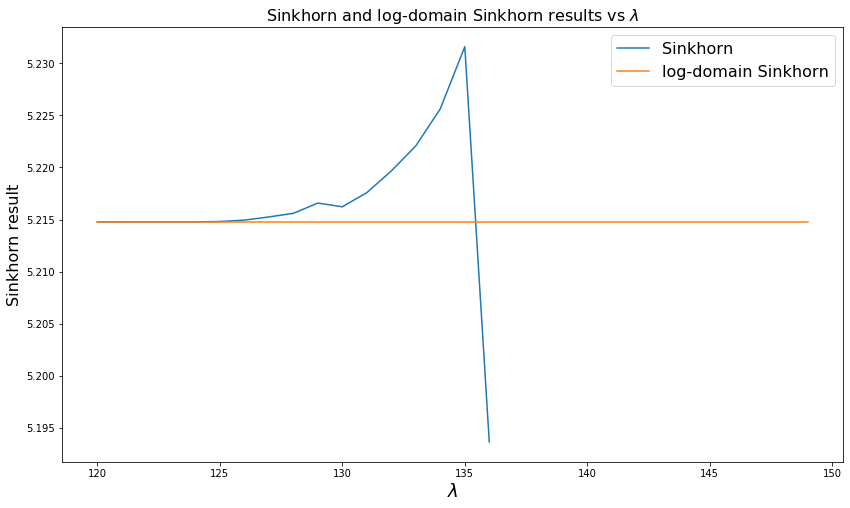

In [16]:
plt.figure(figsize = (14, 8))
plt.plot(lamda, skh_res, label = "Sinkhorn")
plt.plot(lamda, log_skh_res, label = "log-domain Sinkhorn")
plt.xlabel("$\lambda$", fontsize = 18)
plt.ylabel("Sinkhorn result", fontsize = 16)
plt.title("Sinkhorn and log-domain Sinkhorn results vs $\lambda$", fontsize = 16)
plt.legend(fontsize = 16)
pass

We can see that, with $P: Beta(2, 5)$ and $Q: Uniform(5, 6)$, the Sinkhorn algorithm produces inaccurate results with $\lambda > 125$, and the overflow/underflow occurs at $\lambda = 136$. On the other hand, the log-domain Sinkhorn continue to produce relatively accurate result up to $\lambda = 149$. 

## 3. Applications

### 3.1 Empirical Complexity on simulation data

In [73]:
np.random.seed(1)
size = [64, 128, 256, 512, 1024, 2048]
nrep = 10
iter_num_1 = np.zeros((nrep, len(size)))
iter_num_10 = np.zeros((nrep, len(size)))
iter_num_50 = np.zeros((nrep, len(size)))
for j in range(nrep):
    for i in range(6):
        p_samp = np.random.beta(a = 2, b = 5, size = size[i])
        q_samp = np.random.normal(size = size[i])
        M, r, c = sample_to_prob_vec(p_samp, q_samp, sigma = 0)
        iter_num_1[j, i] = Sinkhorn(r, c, M, 1, 1e-11, maxiter)[1]
        iter_num_10[j, i] = Sinkhorn(r, c, M, 10, 1e-11, maxiter)[1]
        iter_num_50[j, i] = Sinkhorn(r, c, M, 50, 1e-11, maxiter)[1]

In [74]:
mean_iter_1 = np.mean(iter_num_1, axis = 0)
mean_iter_10 = np.mean(iter_num_10, axis = 0)
mean_iter_50 = np.mean(iter_num_50, axis = 0)

std_iter_1 = np.std(iter_num_1, axis = 0)
std_iter_10 = np.std(iter_num_10, axis = 0)
std_iter_50 = np.std(iter_num_50, axis = 0)

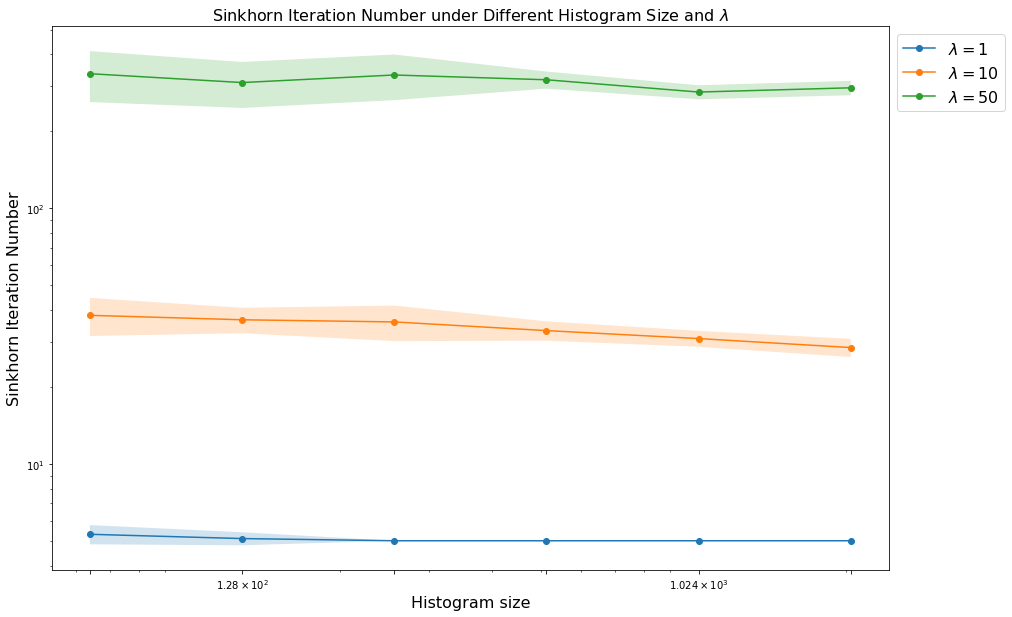

In [75]:
plt.figure(figsize = (15, 10))
plt.plot(size, mean_iter_1, label = "$\lambda = 1$", marker = 'o')
plt.fill_between(size, mean_iter_1 - std_iter_1, mean_iter_1 + std_iter_1, alpha = 0.2)
plt.plot(size, mean_iter_10, label = "$\lambda = 10$", marker = 'o')
plt.fill_between(size, mean_iter_10 - std_iter_10, mean_iter_10 + std_iter_10, alpha = 0.2)
plt.plot(size, mean_iter_50, label = "$\lambda = 50$", marker = 'o')
plt.fill_between(size, mean_iter_50 - std_iter_50, mean_iter_50 + std_iter_50, alpha = 0.2)
plt.yscale('log')
plt.xscale('log')
plt.xticks(ticks = size)
plt.xlabel("Histogram size", fontsize = 16)
plt.ylabel("Sinkhorn Iteration Number", fontsize = 16)
plt.title("Sinkhorn Iteration Number under Different Histogram Size and $\lambda$", fontsize = 16)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 16)
pass

### 3.2 Applications to real data sets

### 3.2.1 Comparative analysis

In this part, we test the algorithm on the MNIST digits dataset as a real world example, which has been used in the original paper[1]. Since earth mover's distance (EMD) is the classical optimal transport distance to measure the difference between probility measures, we also want to compare Sinkhorn distance with EMD when applied to real data sets. According to the theoretical background that Sinkhorn distance $d_M^\lambda(r, c) = \min_{P\in U(r, c)}\langle P, M\rangle-\frac{1}{\lambda}h(P)$, Sinkhorn distance is expected to be larger than EMD due to the regularization and converge to EMD when $\lambda\rightarrow+\infty$. To evaluate this convergence, we choose different $\lambda$ and plot the distribution of deviation $(d_M^\lambda(r, c) - EMD) / EMD$.

1000 pairs of images are chosen from the MNIST digits dataset. Each image would be flattened to a vector of intensities as our input. Cost matrix is the distance between the coordinates of pixels in the image. EMD are calculated using python package *POT* (Python Optimal Transport). 

In [5]:
import scipy.io
import pandas as pd
import ot

In [6]:
mnist = scipy.io.loadmat('data/mnist.mat')
images = mnist.get('trainX')

In [7]:
N = 1000
d = np.sqrt(len(images[1, :]))
lams = [1, 5, 10, 20, 50]
EMD = np.zeros((len(lams), N))
SKH = np.zeros((len(lams), N))
np.random.seed(2)
X1 = np.random.choice(len(images), N)
X2 = np.random.choice(len(images), N)
M = cost_mat(int(d))
p, q = flatten(images[X1, :]), flatten(images[X2, :])

In [34]:
for i, lam in enumerate(lams):
    print(i)
    for j in range(N):
        SKH[i, j] = Sinkhorn(p[j], q[j], M, lam, tol, 5000)[0]
        EMD[i, j] = ot.emd2(p[j], q[j], M)

0
1
2
3
4


In [37]:
df = pd.DataFrame(((SKH - EMD) / EMD).T, columns = ['1', '5','10','20','50'])

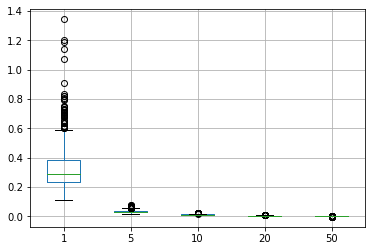

In [38]:
df.boxplot()
pass

As shown in the boxplot, the deviation $(d_M^\lambda(r, c) - EMD) / EMD$ decreases when we use a larger $\lambda$. Especially, when $\lambda$ is $80$, the deviation is close to zero. This is reasonable because when $\lambda$ is larger, the coefficient of regularization term is smaller, and thus Sinkhorn distance becomes closer to EMD.

In [46]:
Sinkhorn(p[1], q[1], M, 1, tol, 5000, log_domain=True)[0]

nan

In [ ]:
Sinkhorn_cpp(p[1], q[1], M, 1, tol, 5000)[0]

In [ ]:
Sinkhorn(p[1], q[1], M, 1, tol, 5000)[0]

In [4]:
! python setup.py sdist bdist_wheel

running sdist
running egg_info
writing sinkhorn_663.egg-info/PKG-INFO
writing dependency_links to sinkhorn_663.egg-info/dependency_links.txt
writing top-level names to sinkhorn_663.egg-info/top_level.txt
reading manifest file 'sinkhorn_663.egg-info/SOURCES.txt'
writing manifest file 'sinkhorn_663.egg-info/SOURCES.txt'
running check
creating sinkhorn_663-0.1
creating sinkhorn_663-0.1/sinkhorn_663
creating sinkhorn_663-0.1/sinkhorn_663.egg-info
creating sinkhorn_663-0.1/sinkhorn_663/image
copying files to sinkhorn_663-0.1...
copying README.md -> sinkhorn_663-0.1
copying setup.py -> sinkhorn_663-0.1
copying sinkhorn_663/__init__.py -> sinkhorn_663-0.1/sinkhorn_663
copying sinkhorn_663/log_domain_skh.py -> sinkhorn_663-0.1/sinkhorn_663
copying sinkhorn_663/sample_to_prob_vec.py -> sinkhorn_663-0.1/sinkhorn_663
copying sinkhorn_663/sinkhorn_main.py -> sinkhorn_663-0.1/sinkhorn_663
copying sinkhorn_663/sinkhorn_numba.py -> sinkhorn_663-0.1/sinkhorn_663
copying sinkhorn_663/skh_cpp.cpp -> sin

In [5]:
! twine upload -r pypitest dist/sinkhorn_663-0.1.tar.gz
! twine upload --repository testpypi dist/*

InvalidConfiguration: Missing 'pypitest' section from the configuration file
or not a complete URL in --repository-url.
Maybe you have an out-dated '~/.pypirc' format?
more info: https://packaging.python.org/specifications/pypirc/



In [3]:
! pip install --index-url https://test.pypi.org/simple/ sinkhorn_663

Looking in indexes: https://test.pypi.org/simple/
  ERROR: Command errored out with exit status 1:
   command: /Users/flora/opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/dg/d8_wtm952rsfp_znt4pcjxzw0000gn/T/pip-install-qmn6d4f6/sinkhorn-663/setup.py'"'"'; __file__='"'"'/private/var/folders/dg/d8_wtm952rsfp_znt4pcjxzw0000gn/T/pip-install-qmn6d4f6/sinkhorn-663/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/dg/d8_wtm952rsfp_znt4pcjxzw0000gn/T/pip-wheel-kd3gkkf3
       cwd: /private/var/folders/dg/d8_wtm952rsfp_znt4pcjxzw0000gn/T/pip-install-qmn6d4f6/sinkhorn-663/
  Complete output (28 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  creating build/lib.macosx-10.9-x86_64-3.8/sinkhorn_663
  cop